In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt

$\frac{1}{4}x_i^{4} + \frac{1}{2}x_i^{2} +x_i$

In [15]:
# def f(x):
#     '''
#     1/4 * x^4 + 1/2 * x^2 + x 
#     '''
#     f = np.zeros(len(x))
#     for i in range(len(x)):
#         f[i] = np.power(x[i], 4)/4 + np.power(x[i], 2)/2 + x[i]
#     return f

f = lambda x: (1/4)*np.power(x, 4) + (1/2)*np.power(x,2) + x #function

def delta_f(x, method = 'e', k = 10):
    '''
    method: default='e'
        e : exact derivative,
        f : forward differences,
        b : backward differences,
        c : centered differences
    k: default=10, value for increment h; is ignored when method='e'
    
    Exact gradient function:
        x^3 + x + 1 
    
    Forward differences:
        (f(x+h) - f(x)) / h

    Backward differences:
        (f(x) - f(x-h)) / h

    Centered differences:
        (f(x+h) - f(x-h)) / 2h
    
    where h = 10^-k norm(x)
    '''
    
    if method == 'e': 
        return np.power(x, 3) + x + 1
    else:
        ga = np.zeros(len(x))
        h = 10**(-k) * np.linalg.norm(x)
        
        if method =='f':
            for i in range(len(x)):
                ga[i] = (f(x[i]+h) - f(x[i])) / h
            return ga   
        elif method =='b':
            for i in range(len(x)):
                ga[i] = (f(x[i]) - f(x[i]-h)) / h
            return ga
        elif method =='c':
            for i in range(len(x)):
                ga[i] = (f(x[i]+h) - f(x[i]-h)) / (2*h)
            return ga     

In [22]:
def descent(x0, kmax, tollgrad, descent_method = 'steepest', alpha = 0.31, grad_method = 'e', grad_method_k = 10):
    '''
    x0: initial points for x
    kmax: max iteration
    tollgrad: tolerance for gradient
    descent_method: default='steepest'
        steepest: steepest descent
        fr: Fletcher Reeves
        pr: Polak Ribier
    alpha: default=0.31, initial alpha
    grad_method: default='e'
        e : exact derivative,
        f : forward differences,
        b : backward differences,
        c : centered differences
    grad_method_k: default=10, value for increment h; is ignored when method='e'
    '''
    
    x = np.zeros((len(x0), kmax+1)) # kmax+1 because we need to also consider x[k+1] case later on
    x[:, 0] = x0
    
    p_k = -delta_f(x0, method = grad_method, k = grad_method_k)
    
    delta_fk_norm = np.linalg.norm(delta_f(x0, method = grad_method, k = grad_method_k))
    
    alpha_k = alpha
    k = 0
    
    # constants for line search algorithm
    rho = 0.45
    jmax = 30
    c1_arm = 10**(-5)
    c2_wol = 0.1
    
    s = time.time()
    if descent_method == 'steepest':
        while(k < kmax and delta_fk_norm >= tollgrad):

            # Find alpha using line search(backtracking method) with respect to the Armijo condition
            j = 0
            while (j < jmax and
                   f(x[:, k] + alpha_k * p_k).sum() > f(x[:, k]).sum() + c1_arm * alpha_k * delta_f(x[:, k], method = grad_method, k = grad_method_k).T @ p_k):
                alpha_k = alpha_k * rho
                j+=1
#                 print(j, alpha_k)

            # Compute the new value for xk
            x[:, k+1] = x[:, k] + alpha_k * p_k

            p_k = -delta_f(x[:, k+1], method = grad_method, k = grad_method_k)

            # Compute the gradient of f in xk
            delta_fk_norm = np.linalg.norm(delta_f(x[:, k+1], method = grad_method, k = grad_method_k))

            # Increase the step by one
            k += 1
            
#             print(f"k:{k}, {x[:, k]}")

    elif descent_method == 'fr':
        gradf_k = delta_f(x0, method = grad_method, k = grad_method_k)
        while(k < kmax and delta_fk_norm >= tollgrad):

            # Find alpha using line search(backtracking method)
            j = 0
            while (j < jmax and 
                (f(x[:, k] + alpha_k * p_k).sum() - f(x[:, k]).sum() - c1_arm * alpha_k * delta_f(x[:, k], method = grad_method, k = grad_method_k).T @ p_k >0.001 and 
                (np.abs(delta_f(x[:, k] + alpha_k * p_k, method = grad_method, k = grad_method_k).T @ p_k) - c2_wol * np.abs(delta_f(x[:, k], method = grad_method, k = grad_method_k).T @ p_k >0.001)))):
                 
                alpha_k = alpha_k * rho
                j+=1
#                 print(j, alpha_k)
#                 print(f(x[:, k] + alpha_k * p_k).sum(),f(x[:, k]).sum() + c1_arm * alpha_k * delta_f(x[:, k], method = grad_method, k = grad_method_k).T @ p_k)
                    

            # Compute the new value for xk
            x[:, k+1] = x[:, k] + alpha_k * p_k

            # Compute the new value for gradfk
            gradf_k1 = delta_f(x[:, k+1], method = grad_method, k = grad_method_k)

            # Compute the new value for betak
            beta_k1 = (gradf_k1.T @ gradf_k1) / (gradf_k.T @ gradf_k) 

            # Compute the new value for pk
            p_k = -gradf_k1 + beta_k1 * p_k

            # Compute the gradient of f in xk
            delta_fk_norm = np.linalg.norm(delta_f(x[:, k+1], method = grad_method, k = grad_method_k))

            # Increase the step by one
            k += 1
            
#             print(f"k:{k}, {x[:, k]}")
    elif descent_method == 'pr':
        gradf_k = delta_f(x0, method = grad_method, k = grad_method_k)
        while(k < kmax and delta_fk_norm >= tollgrad):

            # Find alpha using line search(backtracking method)
            j = 0
            while (j < jmax and 
                (f(x[:, k] + alpha_k * p_k).sum() - f(x[:, k]).sum() - c1_arm * alpha_k * delta_f(x[:, k], method = grad_method, k = grad_method_k).T @ p_k >0.001 and 
                (np.abs(delta_f(x[:, k] + alpha_k * p_k, method = grad_method, k = grad_method_k).T @ p_k) - c2_wol * np.abs(delta_f(x[:, k], method = grad_method, k = grad_method_k).T @ p_k >0.001)))):
                 
                alpha_k = alpha_k * rho
                j+=1
#                 print(j, alpha_k)
                    

            # Compute the new value for xk
            x[:, k+1] = x[:, k] + alpha_k * p_k

            # Compute the new value for gradfk
            gradf_k1 = delta_f(x[:, k+1], method = grad_method, k = grad_method_k)

            # Compute the new value for betak
            beta_k1 = (gradf_k1.T @ (gradf_k1 - gradf_k)) / (gradf_k.T @ gradf_k) 
            
            # Compute the new value for pk
            p_k = -gradf_k1 + beta_k1 * p_k

            # Compute the gradient of f in xk
            delta_fk_norm = np.linalg.norm(delta_f(x[:, k+1], method = grad_method, k = grad_method_k))

            # Increase the step by one
            k += 1
            
#             print(f"k:{k}, {x[:, k]}")
            
    t = time.time() - s
    # Compute f(xk)
    fk = f(x[:, k-1]).sum()

    # "Cut" xseq to the correct size and return
    return x[:, :k], k-1, fk, t



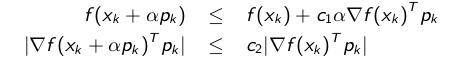

In [6]:
n = 10**4
np.random.seed(288874)
x0 = np.random.random(n)
kmax = 300
tol = 10**(-5)

In [10]:
v = [2, 5, 10]

print(delta_f(v, method='f', k=10))
print(delta_f(v))

[  11.0000006   130.99997006 1010.99959279]
[  11  131 1011]


#### Naming guide

"variable"+ _A _B _C _D (D optional)

    A - length of vector as a power of 10 (10^4, 10^5)

    B - gradient method (e, f, c, b)

    C - descent method (st, pr, fr)

    D - k (2, 4, 6, ..., 12)
    
    
Example: k_4_e_st - iterations with n=10^4, using exact derivative, steepest descent method

# 1. n = 10^4

## A) Exact gradient

### Steepest descent, Fletcher Reeves, Polak Ribier

In [23]:
n = 10**4
np.random.seed(288874)
x0 = np.random.random(n)

x_seq_4_e_st, k_4_e_st, fk_4_e_st, t_4_e_st = descent(x0,  kmax, tol, grad_method='e')
x_seq_4_e_fr, k_4_e_fr, fk_4_e_fr, t_4_e_fr = descent(x0,  kmax, tol, descent_method='fr', grad_method='e')
x_seq_4_e_pr, k_4_e_pr, fk_4_e_pr, t_4_e_pr = descent(x0,  kmax, tol, descent_method='pr', grad_method='e')

print(f"Steepest, exact for 10^4 --- Iteration: {k_4_e_st+1}, time:{t_4_e_st} s")
print(f"Fletcher Reeves, exact for 10^4 --- Iteration: {k_4_e_fr+1}, time:{t_4_e_fr} s")
print(f"Polak Ribier, exact for 10^4 --- Iteration: {k_4_e_pr+1}, time:{t_4_e_pr} s")


Steepest, exact for 10^4 --- Iteration: 15, time:0.07494759559631348 s
Fletcher Reeves, exact for 10^4 --- Iteration: 14, time:0.05388331413269043 s
Polak Ribier, exact for 10^4 --- Iteration: 17, time:0.06692218780517578 s


## B) Forward differences gradient

### Steepest descent

In [26]:
x_seq_k_4_f_st_2, k_k_4_f_st_2, fk_k_4_f_st_2, t_k_4_f_st_2 = descent(x0,  kmax, tol, grad_method='f', grad_method_k=2)

k_k_4_f_st_2, x_seq_k_4_f_st_2[:, k_k_4_f_st_2] # it does not converge when k=2 even with max iteration

(299,
 array([-0.77690584, -0.80669571, -0.79001164, ..., -0.76868856,
        -0.76348641, -0.74433103]))

In [27]:
x_seq_k_4_f_st_4, k_k_4_f_st_4, fk_k_4_f_st_4, t_k_4_f_st_4 = descent(x0,  kmax, tol, grad_method='f', grad_method_k=4)
k_k_4_f_st_4, x_seq_k_4_f_st_4[:, k_k_4_f_st_4] # it does converge when k=4 with max iteration

(299,
 array([-0.68417812, -0.68475658, -0.68446366, ..., -0.68396454,
        -0.68381084, -0.68173708]))

In [28]:
n = 10**4
np.random.seed(288874)
x0 = np.random.random(n)


x_seq_k_4_f_st = [] 
k_k_4_f_st = []
fk_k_4_f_st = []
t_k_4_f_st = []

for i in range(4, 15, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0,  kmax, tol, grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s \n")
    
    x_seq_k_4_f_st.append(x_seq_i)
    k_k_4_f_st.append(k_i)
    fk_k_4_f_st.append(fk_i)
    t_k_4_f_st.append(t_i)

k: 4
Iteration: 300, time:112.8567726612091 s 

k: 6
Iteration: 300, time:114.55893111228943 s 

k: 8
Iteration: 300, time:111.30999660491943 s 

k: 10
Iteration: 15, time:5.087850093841553 s 

k: 12
Iteration: 19, time:6.664440631866455 s 

k: 14
Iteration: 18, time:7.843650579452515 s 



### Fletcher Reeves

In [29]:
n = 10**4
np.random.seed(288874)
x0 = np.random.random(n)


x_seq_k_4_f_fr = [] 
k_k_4_f_fr = []
fk_k_4_f_fr = []
t_k_4_f_fr = []

for i in range(4, 15, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0,  kmax, tol, descent_method='fr', grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s \n")
    
    x_seq_k_4_f_fr.append(x_seq_i)
    k_k_4_f_fr.append(k_i)
    fk_k_4_f_fr.append(fk_i)
    t_k_4_f_fr.append(t_i)

k: 4
Iteration: 300, time:111.32002425193787 s 

k: 6
Iteration: 14, time:4.922631740570068 s 

k: 8
Iteration: 14, time:4.933692455291748 s 

k: 10
Iteration: 14, time:5.06583833694458 s 

k: 12
Iteration: 23, time:8.75761103630066 s 

k: 14
Iteration: 34, time:14.232372760772705 s 



### Polak Ribier

In [30]:
n = 10**4
np.random.seed(288874)
x0 = np.random.random(n)


x_seq_k_4_f_pr = [] 
k_k_4_f_pr = []
fk_k_4_f_pr = []
t_k_4_f_pr = []

for i in range(4, 15, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0,  kmax, tol, descent_method='pr', grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s \n")
    
    x_seq_k_4_f_pr.append(x_seq_i)
    k_k_4_f_pr.append(k_i)
    fk_k_4_f_pr.append(fk_i)
    t_k_4_f_pr.append(t_i)

k: 4
Iteration: 300, time:116.07892155647278 s 

k: 6
Iteration: 17, time:6.269172191619873 s 

k: 8
Iteration: 17, time:6.366508960723877 s 

k: 10
Iteration: 17, time:6.245284557342529 s 

k: 12
Iteration: 46, time:16.573433876037598 s 

k: 14
Iteration: 51, time:18.721948623657227 s 



# 2. n = 10^5

## A) Exact gradient

### Steepest descent, Fletcher Reeves, Polak Ribier

In [31]:
n = 10**5
np.random.seed(288874)
x0 = np.random.random(n)

x_seq_5_e_st, k_5_e_st, fk_5_e_st, t_5_e_st = descent(x0,  kmax, tol, grad_method='e')
x_seq_5_e_fr, k_5_e_fr, fk_5_e_fr, t_5_e_fr = descent(x0,  kmax, tol, descent_method='fr', grad_method='e')
x_seq_5_e_pr, k_5_e_pr, fk_5_e_pr, t_5_e_pr = descent(x0,  kmax, tol, descent_method='pr', grad_method='e')

print(f"Steepest, exact for 10^4 --- Iteration: {k_5_e_st+1}, time:{t_5_e_st} s")
print(f"Fletcher Reeves, exact for 10^4 --- Iteration: {k_5_e_fr+1}, time:{t_5_e_fr} s")
print(f"Polak Ribier, exact for 10^4 --- Iteration: {k_5_e_pr+1}, time:{t_5_e_pr} s")


Steepest, exact for 10^4 --- Iteration: 16, time:0.893566370010376 s
Fletcher Reeves, exact for 10^4 --- Iteration: 15, time:0.8367772102355957 s
Polak Ribier, exact for 10^4 --- Iteration: 18, time:0.9805235862731934 s


## B) Forward difference gradient

### Steepest descent

In [32]:
n = 10**5
np.random.seed(288874)
x0 = np.random.random(n)


x_seq_k_5_f_st = [] 
k_k_5_f_st = []
fk_k_5_f_st = []
t_k_5_f_st = []

for i in range(4, 15, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0,  kmax, tol, grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s \n")
    
    x_seq_k_5_f_st.append(x_seq_i)
    k_k_5_f_st.append(k_i)
    fk_k_5_f_st.append(fk_i)
    t_k_5_f_st.append(t_i)

k: 4
Iteration: 300, time:1134.0428175926208 s 

k: 6
Iteration: 300, time:1063.8334455490112 s 

k: 8
Iteration: 300, time:1100.5457110404968 s 

k: 10
Iteration: 16, time:56.885350465774536 s 

k: 12
Iteration: 19, time:71.42638349533081 s 

k: 14
Iteration: 21, time:76.83855128288269 s 



### Fletcher Reeves

In [33]:
n = 10**5
np.random.seed(288874)
x0 = np.random.random(n)


x_seq_k_5_f_fr = [] 
k_k_5_f_fr = []
fk_k_5_f_fr = []
t_k_5_f_fr = []

for i in range(4, 15, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0,  kmax, tol, descent_method='fr', grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s\n")
    
    x_seq_k_5_f_fr.append(x_seq_i)
    k_k_5_f_fr.append(k_i)
    fk_k_5_f_fr.append(fk_i)
    t_k_5_f_fr.append(t_i)

k: 4
Iteration: 300, time:1070.8488726615906 s

k: 6
Iteration: 15, time:52.20074796676636 s

k: 8
Iteration: 15, time:53.00279378890991 s

k: 10
Iteration: 15, time:55.75055527687073 s

k: 12
Iteration: 300, time:1065.8683197498322 s

k: 14
Iteration: 36, time:123.00361013412476 s



### Polak Ribier

In [34]:
n = 10**5
np.random.seed(288874)
x0 = np.random.random(n)


x_seq_k_5_f_pr = [] 
k_k_5_f_pr = []
fk_k_5_f_pr = []
t_k_5_f_pr = []

for i in range(4, 15, 2):
    print(f"k: {i}")
    x_seq_i, k_i, fk_i, t_i = descent(x0,  kmax, tol, descent_method='pr', grad_method='f', grad_method_k=i)
    
    print(f"Iteration: {k_i+1}, time:{t_i} s\n")
    
    x_seq_k_5_f_pr.append(x_seq_i)
    k_k_5_f_pr.append(k_i)
    fk_k_5_f_pr.append(fk_i)
    t_k_5_f_pr.append(t_i)

k: 4
Iteration: 300, time:1039.8310105800629 s

k: 6
Iteration: 18, time:61.54909825325012 s

k: 8
Iteration: 18, time:62.463219165802 s

k: 10
Iteration: 18, time:61.65953755378723 s

k: 12
Iteration: 300, time:1011.7506356239319 s

k: 14
Iteration: 104, time:349.62147092819214 s



In [35]:
def draw_time_comparison(st, fr, pr, title= ' '):
    fig, ax = plt.subplots(figsize = (10,5))
    plt.grid()

    fig.suptitle('Time comparison graph' + title, fontsize=20)
    ax = plt.plot(range(4, 15, 2), st, 'r-',linewidth=3)
    ax = plt.plot(range(4, 15, 2), fr, 'b--',linewidth=3)
    ax = plt.plot(range(4, 15, 2), pr, 'g-.',linewidth=3)
    plt.legend(['Steepest', 'FR', 'PR'], loc ="upper right", prop={'size': 12})
    plt.xlabel('k parameter of finite difference', fontsize=20)
    plt.ylabel('Iteration time, seconds', fontsize=20)
    plt.tick_params(axis='x', labelsize=20) 
    plt.tick_params(axis='y', labelsize=20)
    
    fig.savefig('Time_'+title+'.eps', format='eps')

def draw_iteration_comparison(st, fr, pr, title= ' '):
    fig, ax = plt.subplots(figsize = (10,5))
    plt.grid()

    fig.suptitle('# of iterations comparison graph' + title, fontsize=20)
    ax = plt.plot(range(4, 15, 2), st, 'r-',linewidth=3)
    ax = plt.plot(range(4, 15, 2), fr, 'b--',linewidth=3)
    ax = plt.plot(range(4, 15, 2), pr, 'g-.',linewidth=3)
    plt.legend(['Steepest', 'FR', 'PR'], loc ="upper right", prop={'size': 12})
    plt.xlabel('k parameter of finite difference', fontsize=20)
    plt.ylabel('Iterations', fontsize=20)
    plt.tick_params(axis='x', labelsize=20) 
    plt.tick_params(axis='y', labelsize=20)
    
    fig.savefig('Iter_'+title+'.eps', format='eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


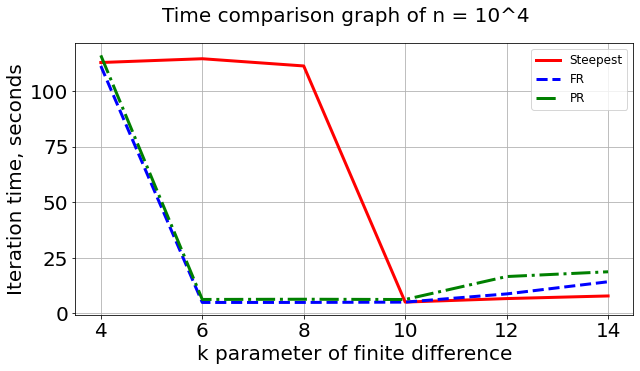

In [36]:
draw_time_comparison(t_k_4_f_st, t_k_4_f_fr, t_k_4_f_pr, ' of n = 10^4')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


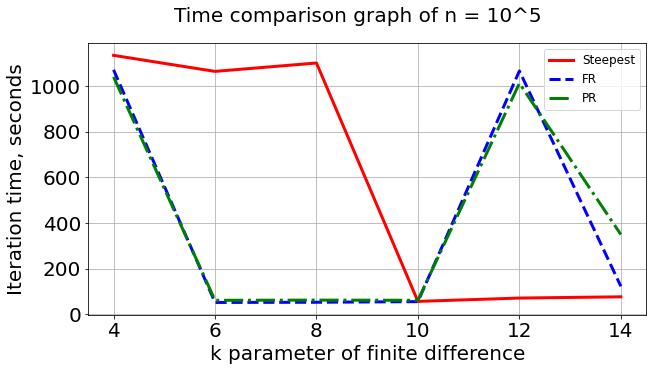

In [37]:
draw_time_comparison(t_k_5_f_st, t_k_5_f_fr, t_k_5_f_pr, ' of n = 10^5')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


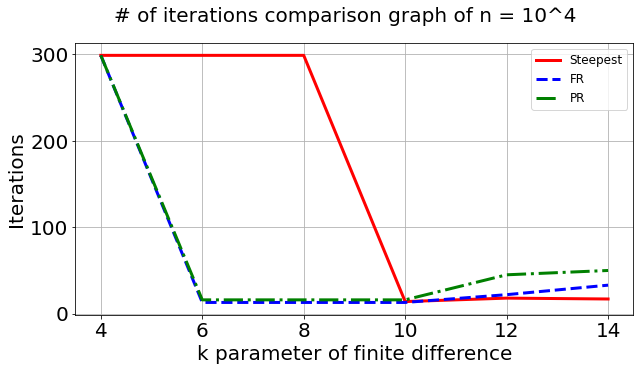

In [38]:
draw_iteration_comparison(k_k_4_f_st, k_k_4_f_fr, k_k_4_f_pr, ' of n = 10^4')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


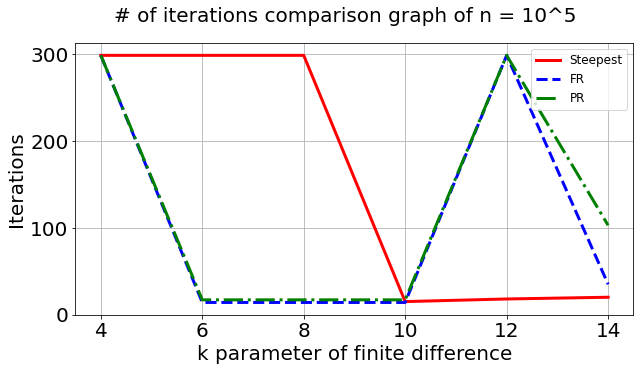

In [39]:
draw_iteration_comparison(k_k_5_f_st, k_k_5_f_fr, k_k_5_f_pr, ' of n = 10^5')